# DAgger
This notebook executes the DAgger algorithm using an expert policy as the "human" model

In [84]:
%matplotlib inline
import pickle
import gym
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tf_util
import load_policy

In [85]:
with open('./expert_data/Ant-v1.pkl', 'rb') as f:
    expert_data = pickle.load(f)
    expert_data['actions'] = expert_data['actions'].squeeze(1)

In [86]:
env = gym.make('Ant-v1')
env.observation_space, env.action_space

[2018-05-30 16:52:52,967] Making new env: Ant-v1


(Box(111,), Box(8,))

In [102]:
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        width = 1000
        self.lin1 = nn.Linear(111, width)
        self.lin2 = nn.Linear(width, width)
        self.lin3 = nn.Linear(width, width)
        self.lin4 = nn.Linear(width, 8)        

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = F.relu(self.lin3(x))
        return self.lin4(x)

In [103]:
expert = load_policy.load_policy('./experts/Ant-v1.pkl')

obs (1, 111) (1, 111)


In [104]:
dagger_policy = Policy()
dagger_optimizer = optim.Adam(dagger_policy.parameters(), lr=0.01)

In [105]:
bc_policy = Policy()
bc_optimizer = optim.Adam(bc_policy.parameters(), lr=0.01)

In [106]:
def train(model, dataloader, optimizer):
    model.train()
    for X, y in dataloader:
        optimizer.zero_grad()
        output = model(X)
        loss = F.mse_loss(output, y)
        loss.backward()
        optimizer.step()
        return loss.item()

In [107]:
def imitate(epochs, model, dataloader, optimizer):
    for epoch in range(1, epochs+1):
        train(model, dataloader, optimizer)

In [108]:
def not_in(A, B):
    nrows, ncols = A.shape
    dtype={'names':['f{}'.format(i) for i in range(ncols)],
           'formats':ncols * [A.dtype]}
    C = A[~np.in1d(A.view(dtype), B.view(dtype))]
    return C.view(A.dtype).reshape(-1, ncols)

In [115]:
def run_policies(num_rollouts, timestep_limit=None):
    with tf.Session():
        tf_util.initialize()
        max_steps = env.spec.timestep_limit if timestep_limit is None else timestep_limit

        names = ['bc', 'expert', 'dagger']
        policies = [bc_policy, expert, dagger_policy]
        named_policies = dict(zip(names, policies))
        results = dict(zip(names, [{'returns': [], 'mean': 0, 'std': 0} for n in names]))
        returns = []
        observations = []
        for i in range(num_rollouts):
            print('iter', i)
            for (name, policy_fn) in named_policies.items():
                obs = env.reset()
                done = False
                totalr = 0.
                steps = 0
                while not done:
                    if name == 'dagger':
                        th_obs = th.from_numpy(obs[None,:]).float()
                        th_action = policy_fn(th_obs)
                        action = th_action.detach().numpy()
                        observations.append(obs)
                    elif name == 'expert':
                        action = policy_fn(obs[None,:])
                    elif name == 'bc':
                        th_obs = th.from_numpy(obs[None,:]).float()
                        th_action = policy_fn(th_obs)
                        action = th_action.detach().numpy()
                    obs, r, done, _ = env.step(action)
                    totalr += r
                    steps += 1
                    env.render()
                    if steps >= max_steps:
                        break
                results[name]['returns'].append(totalr)
        for key in results.keys():
            results[key]['mean'] = np.mean(results[key]['returns'])
            results[key]['std'] = np.std(results[key]['returns'])
        return (np.array(observations), results)

In [110]:
def label_data(data):
    with tf.Session():
        tf_util.initialize()
        return expert(data)

In [112]:
def DAgger(num_iterations, obs, act):
    # Make a plot figure
    fig = plt.figure()
    fig.set_size_inches(10,10)
    ax = fig.gca()
    # Put together the dataset for training
    th_obs = th.from_numpy(obs).float()
    th_act = th.from_numpy(act).squeeze(1).float()
    dataset = TensorDataset(th_obs, th_act)
    dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=10)
    # Train the cloning policy and the DAgger policy
    imitate(100, bc_policy, dataloader, bc_optimizer)
    imitate(100, dagger_policy, dataloader, dagger_optimizer)
    # Keep track of the average returns and std
    plots = {n: {'mean': [], 'std': []} for n in ['bc', 'expert', 'dagger']}
    for i in range(num_iterations):
        print("DAgger Iteration: {}".format(i))
        # Perform roll-outs of all the policies and get their statistics
        obs_pi, stats = run_policies(5, timestep_limit=500)
        for k in stats.keys():
            plots[k]['mean'].append(stats[k]['mean'])
            plots[k]['std'].append(stats[k]['std'])
        # Only keep new observations
        obs_pi = not_in(obs_pi, obs)
        # Have the expert label the new observations
        act_pi = label_data(obs_pi)
        # Update the data
        obs = np.r_[obs, obs_pi]
        act = np.r_[act, act_pi]
        # Put together the dataset for training
        th_obs = th.from_numpy(obs).float()
        th_act = th.from_numpy(act).squeeze(1).float()
        dataset = TensorDataset(th_obs, th_act)
        dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=10)
        # Train the cloning policy and the DAgger policy
        imitate(80, dagger_policy, dataloader, dagger_optimizer)
    # Perform roll-outs of all the policies and get their statistics
    _, stats = run_policies(5, timestep_limit=500)
    for k in stats.keys():
        plots[k]['mean'].append(stats[k]['mean'])
        plots[k]['std'].append(stats[k]['std'])
    for k in plots.keys():
        ax.errorbar(np.arange(num_iterations+1), plots[k]['mean'], yerr=plots[k]['std'],
                    fmt='s--',
                    linewidth=2,
                    elinewidth=0.8,
                    capsize=3,
                    capthick=0.8, label=k)
    plt.legend(loc='lower right')

DAgger Iteration: 0
iter 0
iter 1
iter 2
iter 3
iter 4
DAgger Iteration: 1
iter 0
iter 1
iter 2
iter 3
iter 4
DAgger Iteration: 2
iter 0
iter 1
iter 2
iter 3
iter 4
DAgger Iteration: 3
iter 0
iter 1
iter 2
iter 3
iter 4
DAgger Iteration: 4
iter 0
iter 1
iter 2
iter 3
iter 4
DAgger Iteration: 5
iter 0
iter 1
iter 2
iter 3
iter 4
DAgger Iteration: 6
iter 0
iter 1
iter 2
iter 3
iter 4
DAgger Iteration: 7
iter 0
iter 1
iter 2
iter 3
iter 4
DAgger Iteration: 8
iter 0
iter 1
iter 2
iter 3
iter 4
DAgger Iteration: 9
iter 0
iter 1
iter 2
iter 3
iter 4
iter 0
iter 1
iter 2
iter 3
iter 4


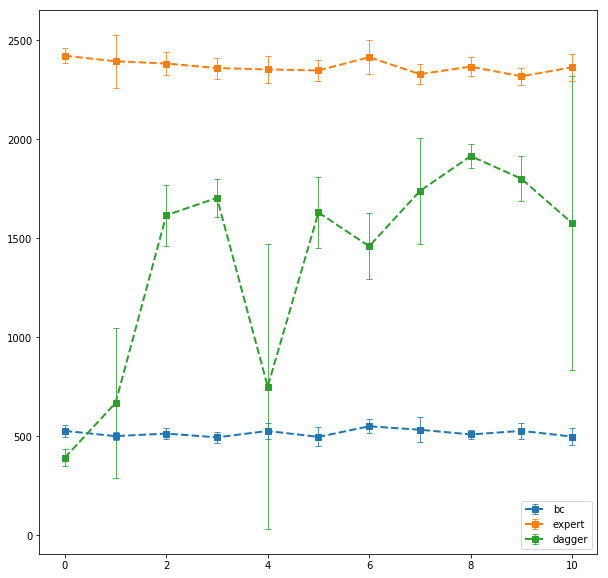

In [113]:
DAgger(10, expert_data['observations'], expert_data['actions'])

In [117]:
_, stats = run_policies(5, timestep_limit=1000)

iter 0
iter 1
iter 2
iter 3
iter 4
